# Backtesting the "Cramer Effect"

**The cramer-effect/cramer-bounce**: After the show *Mad Money* the recommended stocks are bought by viewers almost immediately (afterhours trading) or on the next day at market open, increasing the price for a short period of time.

**Facts:**
- Mad money is from 6:00 PM to 7:00 PM ET
    - (This is 10:00 PM 11:00 PM UTC+0) 
- NYSE is open from 9:30 AM to 4:00 PM ET
    - (This is 1:30 PM to 8:00 PM UTC+0)

**Because of the above:**
- People buy the mentioned stocks
    - After the show (7:00 PM ET)
        - As there is no (free) reliable afterhours market data, we will approximate the stock price as the price at 4:00 PM ET (NYSE Close)
    - Next trading day at Open
- The increase is for a short period of time, but there are no exact figures, we can test on multiple hold periods
    - Next day Close
    - 1, 2, 3, ... days at Close
- (If the show was on Friday night, we won't care about it and won't buy or sell) --> TODO: Should we use the next available business date? e.g. monday?

**Refs:**
- https://www.investopedia.com/terms/c/cramerbounce.asp
- https://www.kiplinger.com/article/investing/t031-c023-s001-the-cramer-effect.html
- https://www.davemanuel.com/investor-dictionary/cramer-effect/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter
from datetime import datetime, timedelta
from typing import List
import concurrent.futures
import warnings

import numpy as np
import pandas as pd
import backtesting
from tqdm import tqdm
import yfinance

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import mad_money_backtesting as mmb

C:\Users\vecse\anaconda3\lib\site-packages\backtesting\_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
warnings.simplefilter("ignore")

# Constants

In [4]:
BACKTEST_FROM = "2020-01-01"
CASH_PER_STOCK = 1000 # if a stocks price is bigger than this, we will skip it
COMMISSION_RATE = 0.02

In [5]:
nb_business_days = len(pd.bdate_range(BACKTEST_FROM, datetime.now()))
print(f"Number of business days needed to fully test the stocks: {nb_business_days}")

Number of business days needed to fully test the stocks: 364


# Read the csv

In [6]:
df = pd.read_csv("mad_money.csv", parse_dates=["date"])

In [7]:
df.head()

,Unnamed: 0,name,month_and_day,segment,call,current_price,date,symbol
0,0,CrowdStrike (CRWD),01/03,I,buy,50.75,2020-01-03,CRWD
1,1,Lam Research (LRCX),01/03,D,buy,294.69,2020-01-03,LRCX
2,2,Microsoft (MSFT),01/03,D,buy,158.62,2020-01-03,MSFT
3,3,Nike (NKE),01/03,D,buy,101.92,2020-01-03,NKE
4,4,Procter & Gamble (PG),01/03,D,buy,122.58,2020-01-03,PG


# Filter the data

## Call type filter

We only care about the "buy" mentions, but this can be extended to the "positive" mentions as well

In [8]:
df = df[df["call"] == "buy"]

# Backtest all mentioned stocks

## Filter based on the date

In [9]:
if BACKTEST_FROM is None:
    BACKTEST_FROM = df["date"].values[0]

In [10]:
df = df[df["date"] >= BACKTEST_FROM]

In [11]:
print(f"Backtesting starts from {df.date.values[0]} and lasts until {df.date.values[-1]}")

Backtesting starts from 2020-01-03T00:00:00.000000000 and lasts until 2021-05-21T00:00:00.000000000


## Filter Fridays

Fridays are filtered because what we buy at Friday, we can only sell at Monday, which is not an optimal scenario for short time hype

(TODO: do we always want to filter them?)

In [12]:
df = df[df["date"].dt.day_name() != "Friday"]

## Define backtesting for a single stock

With the `backtesting.py` framework every single stock is backtested separately. For each stock we have `X` money which we are willing to spend (e.g. $5k), this is defined at the start of the notebook.

At every "buy recommendation date" by Cramer we calculate when we want to buy and sell (see below).

On the buy dates we go all-in with the money which we have (which is left) for the stock, and every sell date, we sell every long position.

**TODO: how to create a class for date calc?**

In [13]:
def backtest_single_stock(strategy_class, symbol, mad_money_df, cash, commission, stop_loss_perc=None, take_profit_perc=None):
    # Get the dates when the Stock was recommended
    recommendation_dates = mad_money_df[mad_money_df["symbol"] == symbol]["date"]
    recommendation_dates = [mmb.pd_date_to_datetime(x) for x in recommendation_dates]
    
    # Download the stock data - with pre and post data
    # TODO: number of days should be a parameter
    stock_df = yfinance.Ticker(symbol).history(period=f"364d", interval="1h", prepost=True)
    if len(stock_df) < 1:
        raise ValueError(f"There is not data in the dataframe for: {symbol}")
    stock_df["Date"] = stock_df.index
    stock_df.dropna(inplace=True)
    
    # Run the backtesting with our strategy
    bt = backtesting.Backtest(stock_df, strategy_class, cash=cash, commission=commission, trade_on_close=True)
    results = bt.run(recommendation_dates=recommendation_dates,
                     stop_loss_perc=stop_loss_perc,
                     take_profit_perc=take_profit_perc)
    
    return bt, results

## Run backtests

In [14]:
stocks_to_backtest = df["symbol"].unique()
pbar = tqdm(total=len(stocks_to_backtest))

bt_results = {}
symbols_not_used_at_the_end = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {}
    
    for symbol in stocks_to_backtest:
        f = executor.submit(backtest_single_stock,
                            strategy_class=mmb.NextDayOpenBuyNextDayCloseSell,
                            symbol=symbol,
                            mad_money_df=df,
                            cash=CASH_PER_STOCK,
                            commission=COMMISSION_RATE)
        futures[f] = symbol
        
    for f in concurrent.futures.as_completed(futures):
        symbol = futures[f]
        
        try:
            bt_obj, bt_result = f.result()
            bt_results[symbol] = {"obj":bt_obj, "result":bt_result}
        except Exception as e:
            # print(f"There was a problem with {symbol} - {e}")
            symbols_not_used_at_the_end.append(symbol)
            
        pbar.update(1)
            
pbar.close()

  0%|▌                                                                                                                                                                                                                  | 2/680 [00:00<07:07,  1.59it/s]

- AAXN: No data found, symbol may be delisted


  6%|█████████████▌                                                                                                                                                                                                    | 44/680 [00:13<01:46,  6.00it/s]

- BRK.B: No data found, symbol may be delisted


  7%|█████████████▉                                                                                                                                                                                                    | 45/680 [00:13<01:55,  5.49it/s]

- UTX: No data found, symbol may be delisted


 19%|███████████████████████████████████████▋                                                                                                                                                                         | 129/680 [00:35<02:55,  3.13it/s]

- RTN: No data found, symbol may be delisted


 24%|███████████████████████████████████████████████████                                                                                                                                                              | 166/680 [00:46<04:45,  1.80it/s]

- LVGO: No data found, symbol may be delisted


 27%|███████████████████████████████████████████████████████▉                                                                                                                                                         | 182/680 [00:48<01:45,  4.72it/s]

- AIMT: No data found, symbol may be delisted


 29%|███████████████████████████████████████████████████████████▉                                                                                                                                                     | 195/680 [00:52<02:48,  2.88it/s]

- SQ : No data found, symbol may be delisted


 46%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 314/680 [01:20<01:51,  3.29it/s]

- PE: No data found, symbol may be delisted


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 398/680 [01:41<01:10,  4.02it/s]

- CCH: No data found, symbol may be delisted
- RST: No data found, symbol may be delisted


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 412/680 [01:43<01:10,  3.80it/s]

- SERV: No data found, symbol may be delisted


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 442/680 [01:51<01:09,  3.44it/s]

- MU : No data found, symbol may be delisted


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 463/680 [01:56<01:44,  2.09it/s]

- SEAH.U: No data found, symbol may be delisted


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 542/680 [02:14<00:22,  6.08it/s]

- PIC: No data found, symbol may be delisted


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 546/680 [02:15<00:35,  3.73it/s]

- NK: No data found, symbol may be delisted


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 561/680 [02:18<00:28,  4.19it/s]

- FCAU: No data found, symbol may be delisted


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 565/680 [02:19<00:30,  3.80it/s]

- SBE: No data found, symbol may be delisted


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [02:43<00:00,  4.15it/s]


In [15]:
print(f"These symbols were not backtested, but Cramer mentioned them: {symbols_not_used_at_the_end}")

These symbols were not backtested, but Cramer mentioned them: ['AAXN', 'BRK.B', 'UTX', 'HON', 'RTN', 'LVGO', 'AIMT', 'SQ ', 'PE', 'RST', 'CCH', 'SERV', 'MU ', 'SEAH.U', 'PIC', 'NK', 'FCAU', 'SBE']


# Results

In [16]:
results_df = mmb.summarize_backtesting_results(results=[x["result"] for x in bt_results.values()],
                                               symbols=list(bt_results.keys()),
                                               include_parameters=False,
                                               sort_by="Return [%]")

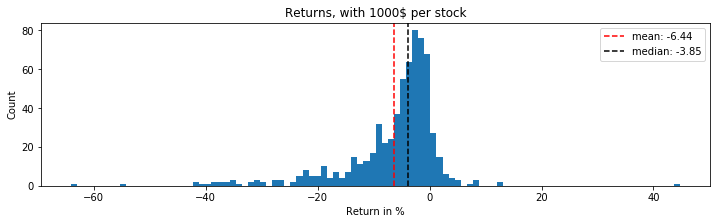

In [17]:
returns_perc = results_df["Return [%]"].values

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.hist(returns_perc, bins=100)
ax.set_title(f"Returns, with {CASH_PER_STOCK}$ per stock")
ax.set_ylabel("Count")
ax.set_xlabel("Return in %")
ax.axvline(returns_perc.mean(), color="red", linestyle="--", label=f"mean: {returns_perc.mean():.2f}")
ax.axvline(np.median(returns_perc), color="black", linestyle="--", label=f"median: {np.median(returns_perc):.2f}")
ax.legend();

## Complete stock list

In [18]:
results_df.style.background_gradient(cmap="magma_r")

,Return [%],Equity Final [$],Equity Peak [$],Buy & Hold Return [%],Start,End
Strategy,,,,,,
NextDayOpenBuyNextDayCloseSell (INO),44.750078,1447.500785,1447.500785,162.942275,2019-12-12 09:30:00-05:00,2021-05-21 16:00:03-04:00
NextDayOpenBuyNextDayCloseSell (FSR),12.483496,1124.834959,1277.691856,47.399530,2020-10-30 04:00:00-04:00,2021-05-21 16:00:02-04:00
NextDayOpenBuyNextDayCloseSell (LVMUY),12.210593,1122.105930,1124.779849,73.680666,2019-12-12 09:30:00-05:00,2021-05-24 11:39:13-04:00
NextDayOpenBuyNextDayCloseSell (MRNA),8.630855,1086.308548,1095.798049,771.289784,2019-12-12 09:00:00-05:00,2021-05-21 16:00:02-04:00
NextDayOpenBuyNextDayCloseSell (VERU),8.003536,1080.035358,1298.298145,205.263154,2019-12-12 04:00:00-05:00,2021-05-21 16:00:03-04:00
NextDayOpenBuyNextDayCloseSell (GRTS),7.942197,1079.421967,1138.217754,-21.705425,2019-12-12 08:00:00-05:00,2021-05-21 16:00:02-04:00
NextDayOpenBuyNextDayCloseSell (BILL),7.377787,1073.777869,1086.635314,561.590923,2019-12-12 09:30:00-05:00,2021-05-21 16:00:02-04:00
NextDayOpenBuyNextDayCloseSell (BFT),5.274561,1052.745612,1052.745612,55.509787,2020-10-09 10:30:00-04:00,2021-03-30 16:00:02-04:00
NextDayOpenBuyNextDayCloseSell (SFIX),4.997302,1049.973025,1061.253032,69.764683,2019-12-12 08:00:00-05:00,2021-05-21 16:00:02-04:00


## Individual stock inspection

In [19]:
# If you would like to inspect the backtesting plot of any individual stock, just uncomment the following cells/lines
# symbol_to_inspect = "F"
# df[df["symbol"] == symbol_to_inspect]

In [20]:
# bt_results[symbol_to_inspect]["result"]._equity_curve                        
# bt_results[symbol_to_inspect]["obj"].plot(resample="D")